# Packages

In [7]:

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Test of stationarity
from statsmodels.tsa.stattools import adfuller
# Linear Optimization
from scipy.optimize import minimize
# import Portfolio class
import yfinance as yf

from src.pnl_portfolio import Portfolio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Analysis

## Functions for data analysis

In [8]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Functions for empirical moments
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)

    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat

def create_stock_dataframe(tickers, start_date, end_date):
    data = {} 

    for ticker in tickers:
        # Pour télécharger les données boursières avec une fréquence mensuelle "1mo"
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
        # Pour extraire et stocker les prix de clôture ajustés "Adj Close"
        data[ticker] = stock_data['Adj Close']
    df = pd.DataFrame(data)
    
    return df

## Download and clean data


In [10]:
# Création du DataFrame
tickers = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
start_date = '2020-01-01'
end_date = '2023-12-01'
stock_df = create_stock_dataframe(tickers, start_date, end_date)
stock_df.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,JPM,BP,AAPL,JNJ,MSFT,PG,V,HD,GE,PFE
Date,,,,,,,,,,
2020-01-01,116.565918,29.154236,75.383644,133.691208,164.040085,112.892738,193.532990,207.160843,76.554207,30.266418
2020-02-01,102.911438,25.248718,66.579010,120.768425,156.118958,103.184013,176.793259,197.842712,66.900383,27.439217
2020-03-01,79.796021,20.020256,62.081348,118.510918,152.390472,100.240578,156.944214,169.570374,48.822521,26.798803
2020-04-01,84.874695,19.535961,71.727180,135.601166,173.165268,107.412331,174.088089,200.985733,41.854263,31.495161
2020-05-01,87.144722,18.994202,77.620605,134.435272,177.068970,106.339813,190.179962,227.179825,40.438599,31.355587


## Plot index evolution


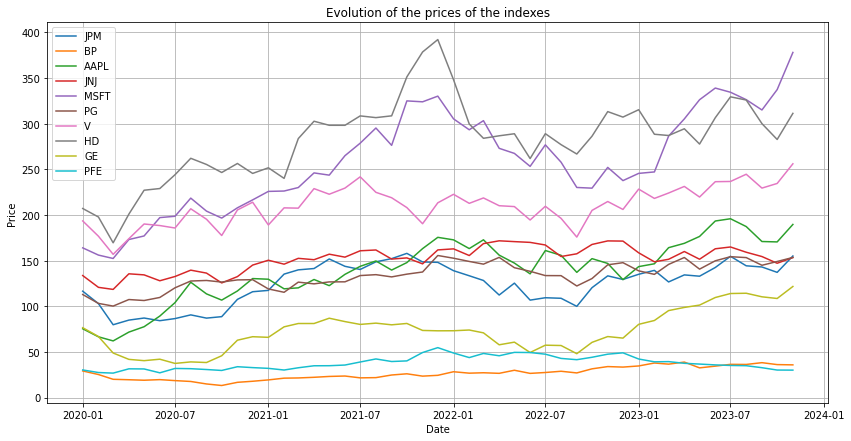

In [11]:
plt.figure(figsize=(14, 7))
for c in stock_df.columns.values:
    plt.plot(stock_df.index, stock_df[c], label=c)
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of the prices of the indexes')
plt.show()

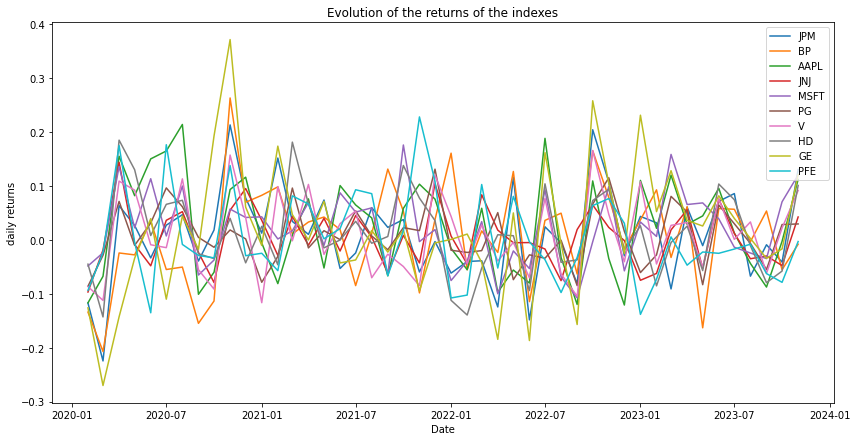

In [12]:
returns = stock_df.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], label=c)
plt.legend()
plt.ylabel('daily returns')
plt.xlabel('Date')
plt.title('Evolution of the returns of the indexes')
plt.show()

# Frontier Efficient and Maximization problem 

In this part, we are going to find the efficient frontier and to maximize our esg-mean-variance problem.


## Test the stationarity of the returns

In [13]:
P_VALUE = 0.01
Y = returns+1
Y_full = Y.iloc[1:]

for index in Y.columns:
    # ADF Test for Stationarity
    result = adfuller(Y_full[index].values, autolag='AIC')

    # Extract and print the results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('__________________________')
    print(f'Stationarity test for {index} index')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= P_VALUE:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely stationary (reject the null hypothesis of non-stationarity).')
    else:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely non-stationary (fail to reject the null hypothesis).')

__________________________
Stationarity test for JPM index
ADF Statistic: -3.207295607199965
p-value: 0.019566245679309473
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338
Then for a p-value of 0.01, the time series is likely non-stationary (fail to reject the null hypothesis).
__________________________
Stationarity test for BP index
ADF Statistic: -6.570944409314353
p-value: 7.93915597995259e-09
Critical Values:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for AAPL index
ADF Statistic: -5.750899034171255
p-value: 5.969984392387229e-07
Critical Values:
   1%: -3.5885733964124715
   5%: -2.929885661157025
   10%: -2.6031845661157025
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
_

## Traditional ESG-MEAN-VARIANCE Optimization

### Net Return:

The net return is the actual return earned by the investor after deducting any fees or expenses. It is calculated as the difference between the ending value of the portfolio $ V_e $ and the beginning value of the portfolio $ V_b $, divided by the beginning value:


$
\text{Net Return} = \frac{V_e - V_b}{V_b}
$



### Gross Return :

The gross return is the total return of the portfolio before deducting any fees or expenses. It is calculated as the difference between the ending value of the portfolio $ V_e $ and the beginning value of the portfolio $ V_b $, divided by the beginning value:

$
\text{Gross Return} = \frac{V_e}{V_b}
$


### Sharpe Ratio

The Sharpe ratio measures the risk-adjusted performance of an investment or portfolio. It is calculated as the ratio of the excess return of the portfolio $R_p - R_f$ to its standard deviation $ \sigma_p $, where $ R_p $ is the $\textbf{net}$ expected portfolio return, $ R_f $ is the risk-free rate, and $ \sigma_p $ is the standard deviation of the portfolio's excess return:

$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$

### Markowitz Problem 

In [14]:
TICKERS = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
START_DATE = '2019-01-01'
END_DATE = '2023-12-01'
INTERVAL = '1mo' # '1d', '1y'
# Sustainalytics scores of the stocks (the smaller the better)
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3, 24, 15, 29, 17, 13, 41, 25]


M_PORTFOLIO = Portfolio(TICKERS,
                      START_DATE,
                      END_DATE,
                      INTERVAL,
                      SUSTAINALYTICS_SCORES,'M')
Y_PORTFOLIO=Portfolio(TICKERS,
                      START_DATE,
                      END_DATE,
                      INTERVAL,
                      SUSTAINALYTICS_SCORES,'Y')
                      

### Sharpe ratio analysis for each asset

Analyse des sharpes ratios par asset pour vérifier l'ordre de grandeur
Superposer l'evolution du sharpe ratio pour chaque actif 

In [15]:
import pandas as pd
import numpy as np

TICKERS = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
START_DATE = '2019-01-01'
END_DATE = '2023-12-01'
INTERVAL = '1mo' # '1d', '1y'
# Sustainalytics scores of the stocks (the smaller the better)
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3, 24, 15, 29, 17, 13, 41, 25]
stock_data = yf.download(tickers=TICKERS, 
                            start=START_DATE,
                            end=END_DATE,
                            interval=INTERVAL)
# Pour extraire et stocker les prix de clôture ajustés "Adj Close"
stock_dataframe = stock_data['Adj Close']

# Step 1: Calculate monthly returns
returns = stock_dataframe.pct_change()

# Step 2: Calculate average return and standard deviation of returns
average_return = returns.mean()
std_dev_return = returns.std()

risk_free_rate = 0.03

# Step 3: Calculate Sharpe ratio for each stock
sharpe_ratios = (average_return - risk_free_rate) / std_dev_return

# Display the Sharpe ratios
print("Sharpe Ratios:")
print(np.mean(sharpe_ratios))


[*********************100%%**********************]  10 of 10 completed
Sharpe Ratios:
-0.23018709721054903


Therefore, we should have a sharpe ratio near -0.23 

**Let's try with annualized returns**

In [16]:
Y_PORTFOLIO.download_data()
average_annualized_return = Y_PORTFOLIO.gross_returns.mean()
std_dev_annualized_return = Y_PORTFOLIO.gross_returns.std()

risk_free_rate = 0.03

# Step 3: Calculate Sharpe ratio for each stock
sharpe_ratios_annualized = (average_annualized_return - risk_free_rate) / std_dev_annualized_return

# Display the Sharpe ratios
print("Sharpe Ratios:")
print(np.mean(sharpe_ratios_annualized))

[*********************100%%**********************]  10 of 10 completed
Sharpe Ratios:
0.530827769462146


We should have a sharpe ratio near 0.53 

### Monthly returns portfolio study



[*********************100%%**********************]  10 of 10 completed


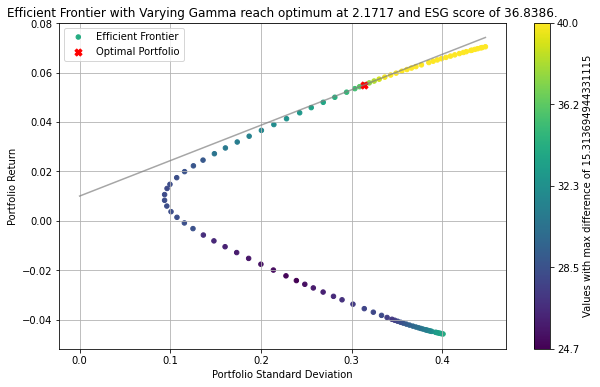

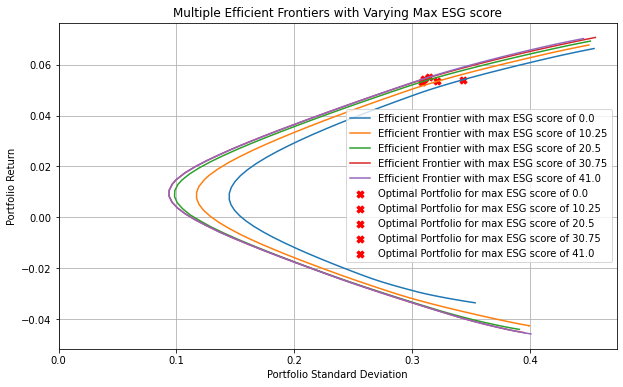

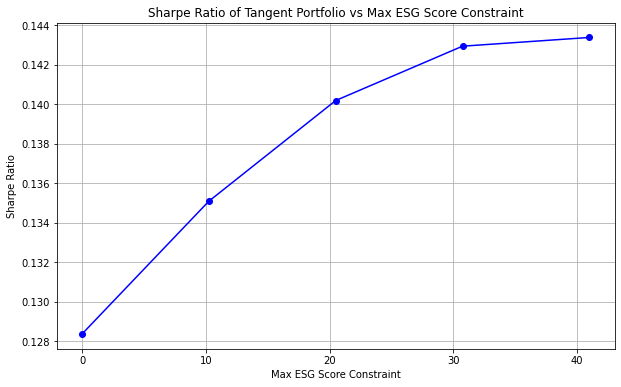

In [17]:
M_PORTFOLIO.download_data()
# Maximum ESG score constraints
MAX_ESG_SCORE = 40
# proportion of risk-free asset in the portfolio
ALPHA = 0.9 #the alpha is useless for now
# risk-free rate
RISK_FREE_RATE = 0.01
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100) 

MAX_ESG_SCORES = list(np.linspace(0, np.max(SUSTAINALYTICS_SCORES), 5))

M_PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  ALPHA,
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=False,opt_problem='Markowitz')

M_PORTFOLIO.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES,
                                                            ALPHA,
                                                            risk_free_rate=RISK_FREE_RATE,
                                                            max_esg_scores=MAX_ESG_SCORES,
                                                            fully_invested=True,
                                                            long_only=False,
                                                            with_optimal_portfolio=True,
                                                            with_linear_tangent=False,opt_problem='Markowitz')
M_PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        ALPHA,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=False,opt_problem='Markowitz')                                                     

### Annualized yearly return porftolio studies

[*********************100%%**********************]  10 of 10 completed


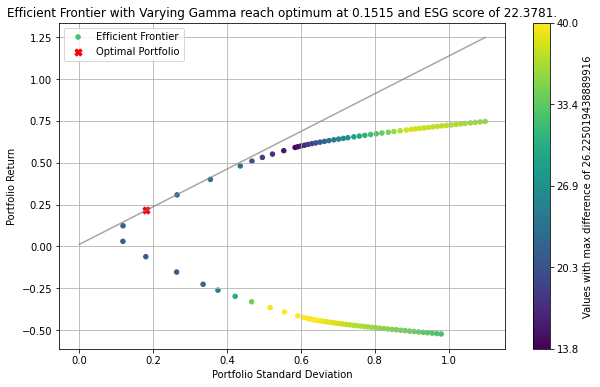

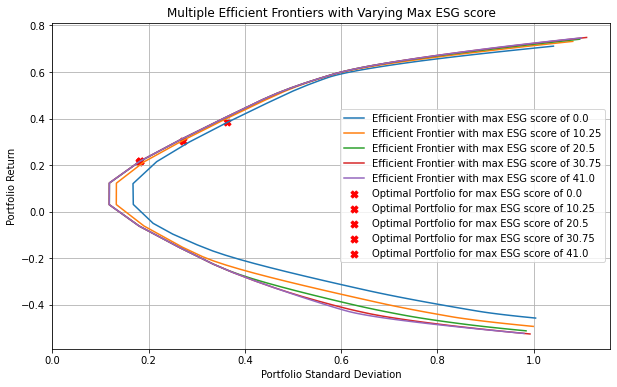

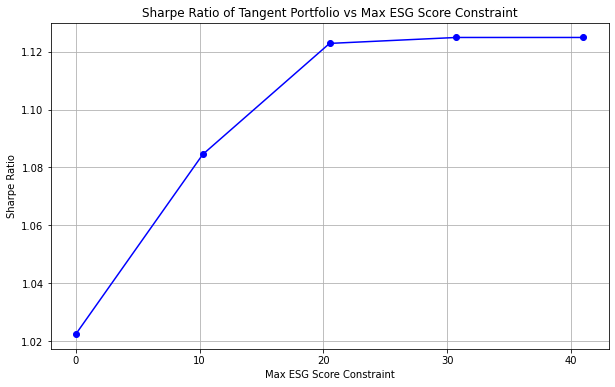

In [18]:
Y_PORTFOLIO.download_data()
# Maximum ESG score constraints
MAX_ESG_SCORE = 40
# propostion of risk-free asset in the portfolio
ALPHA = 0.9
# risk-free rate
RISK_FREE_RATE = Y_PORTFOLIO.risk_annualized_free_rate
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100) 

MAX_ESG_SCORES = list(np.linspace(0, np.max(SUSTAINALYTICS_SCORES), 5))

Y_PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  ALPHA,
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=False)

Y_PORTFOLIO.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES,
                                                            ALPHA,
                                                            risk_free_rate=RISK_FREE_RATE,
                                                            max_esg_scores=MAX_ESG_SCORES,
                                                            fully_invested=True,
                                                            long_only=False,
                                                            with_optimal_portfolio=True,
                                                            with_linear_tangent=False)
Y_PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        ALPHA,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=False)                                                     

### Use of an Average 3-Month Treasury Bill Yield as risk free rate

In [19]:
import yfinance as yf
from datetime import datetime

def get_average_treasury_bill_yield(start_date, end_date):
    # Define the Treasury bill symbol (3-Month Treasury Bill)
    treasury_bill_symbol = '^IRX'

    # Fetch historical data for the Treasury bill
    treasury_bill_data = yf.download(treasury_bill_symbol, start=start_date, end=end_date)

    # Calculate the average yield over the period
    average_yield = treasury_bill_data['Close'].mean()

    return average_yield

# Set your own start_date and end_date
start_date = '2020-01-01'
end_date = '2024-01-01'

# Get and print the average 3-month Treasury bill yield over the specified period
average_treasury_bill_yield = get_average_treasury_bill_yield(start_date, end_date)

risk_free_rate_yield=average_treasury_bill_yield/100
print(f"Average 3-Month Treasury Bill Yield ({start_date} to {end_date}): {average_treasury_bill_yield:.4f}%")


[*********************100%%**********************]  1 of 1 completed
Average 3-Month Treasury Bill Yield (2020-01-01 to 2024-01-01): 1.8447%


[*********************100%%**********************]  10 of 10 completed


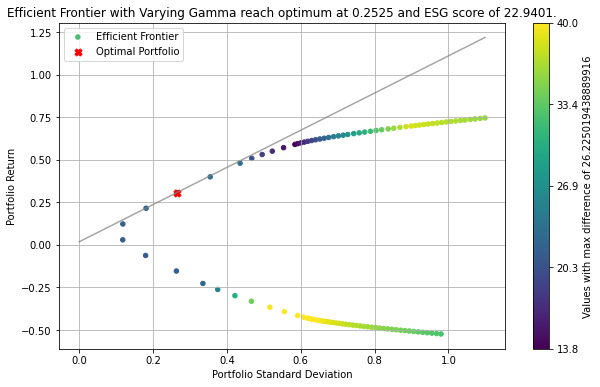

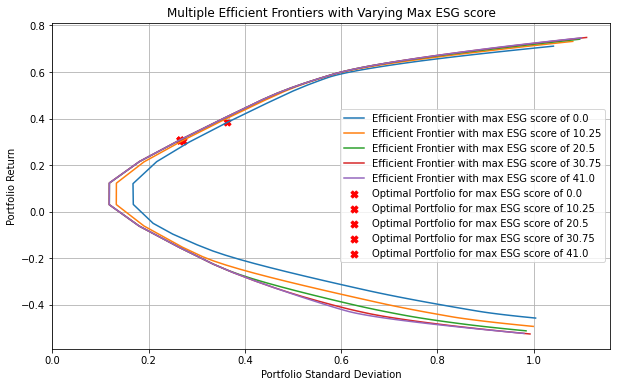

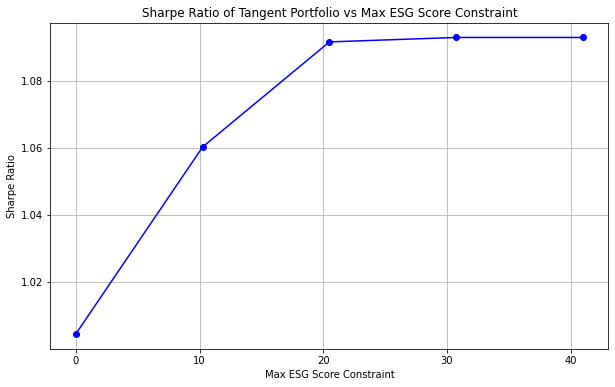

In [20]:
Y_PORTFOLIO.download_data()
# Maximum ESG score constraints
MAX_ESG_SCORE = 40
# propostion of risk-free asset in the portfolio
ALPHA = 0.9
# risk-free rate
RISK_FREE_RATE = risk_free_rate_yield
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100) 

MAX_ESG_SCORES = list(np.linspace(0, np.max(SUSTAINALYTICS_SCORES), 5))

Y_PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  ALPHA,
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=False)

Y_PORTFOLIO.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES,
                                                            ALPHA,
                                                            risk_free_rate=RISK_FREE_RATE,
                                                            max_esg_scores=MAX_ESG_SCORES,
                                                            fully_invested=True,
                                                            long_only=False,
                                                            with_optimal_portfolio=True,
                                                            with_linear_tangent=False)
Y_PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        ALPHA,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=False)                                                     

### Pedersen Model

#### Theory of the Pedersen Model

**Proposition 1:** 


The Pedersen model propose a different maximization problem involving the esg criteria. In this model, the investor should choose her average ESG score $\overline{s}$ to maximize the following function of the squared Sharpe Ratio and the ESG preference function f :(in our case $f=identity$)

$$ \max_{\overline{s}}[(SR(\overline{s}))^2+2\gamma f(\overline{s})]$$

where SR is the sharpe ratio.


**Propostion 2:**

*The Maximum Sharpe ratio* $SR(\overline{s})$ is reached at 

$$SR(\overline{s})=\sqrt{c_{\mu,\mu}-\frac{(c_{s,\mu}-\overline{s}c_{1,\mu})^2}{c_{s,s}-2\overline{s}c_{1,s}+\overline{s}^2c_{1,1}}}$$

where $c_{a,b}=a^{'}\Sigma b$ with $\mu$ the expected return and $\Sigma$ the varianca covaraince matrix

**Proposition 3: (Four fund separation)**

Given an average ESG score $\overline{s}$, the optimal portfolio 

$$ x=\frac{1}{\gamma} \Sigma^{-1}(\mu +\pi(s-1\overline{s}))$$ 

as long as $x^{'}1>0$ where

$$\pi=c_{\mu,\mu}-\frac{(c_{s,\mu}-\overline{s}c_{1,\mu})^2}{c_{s,s}-2\overline{s}c_{1,s}+\overline{s}^2c_{1,1}}$$



In [ ]:

#########################
#  NEEDS TO BE CHANGED  #
#########################



# TICKERS = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
# START_DATE = '2019-01-01'
# END_DATE = '2023-12-01'
# INTERVAL = '1mo' # '1d', '1y'
# # Sustainalytics scores of the stocks (the smaller the better)
# SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3, 24, 15, 29, 17, 13, 41, 25]


# Y_PORTFOLIO_diff_opt=Portfolio(TICKERS,
#                       START_DATE,
#                       END_DATE,
#                       INTERVAL,
#                       SUSTAINALYTICS_SCORES,'Y')

                      
# Y_PORTFOLIO_diff_opt.download_data()

# MAX_ESG_SCORE = 40
# # propostion of risk-free asset in the portfolio
# ALPHA = 0.9
# # risk-free rate treasury bill 3 months
# RISK_FREE_RATE = 0.018
# # Set gamma values
# GAMMA_VALUES = np.linspace(-5, 5, 100) 

# MAX_ESG_SCORES = list(np.linspace(0, np.max(SUSTAINALYTICS_SCORES), 5))

# Y_PORTFOLIO_diff_opt.plot_efficient_frontier(GAMMA_VALUES, 
#                                   ALPHA,
#                                   risk_free_rate=RISK_FREE_RATE,
#                                   max_esg_score=MAX_ESG_SCORE,
#                                   fully_invested=True,
#                                   long_only=False,best_in_class_method=False,opt_problem='Pedersen')

# Y_PORTFOLIO_diff_opt.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES,
#                                                             ALPHA,
#                                                             risk_free_rate=RISK_FREE_RATE,
#                                                             max_esg_scores=MAX_ESG_SCORES,
#                                                             fully_invested=True,
#                                                             long_only=False,best_in_class_method=False,
#                                                             with_optimal_portfolio=True,
#                                                             with_linear_tangent=False,opt_problem='Pedersen')
# Y_PORTFOLIO_diff_opt.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         ALPHA,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=False,best_in_class_method=False,opt_problem='Pedersen')    

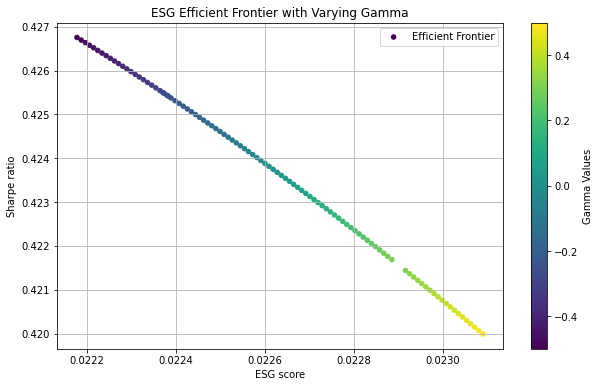

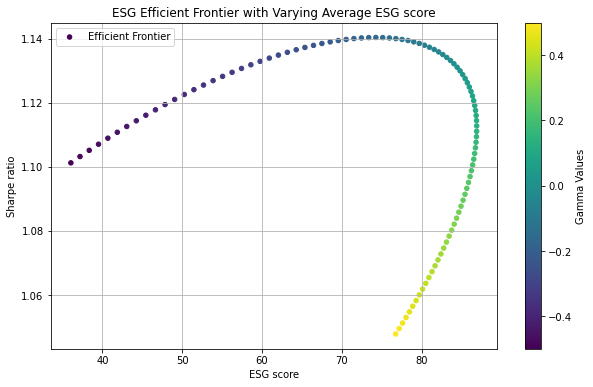

In [21]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

SUSTAINALYTICS_SCORES_ = np.array(SUSTAINALYTICS_SCORES)*0.001

def Cab(a,b):
    return a @ np.linalg.inv(cov_matrix) @ b
def objective_perderson(weights, gamma, returns, cov_matrix):
    s_ = np.dot(SUSTAINALYTICS_SCORES_,weights)
    Cmumu = Cab(returns,returns)
    Csmu = Cab(SUSTAINALYTICS_SCORES_,returns)
    C1mu = Cab(np.ones(len(returns)),returns)
    Css = Cab(SUSTAINALYTICS_SCORES_,SUSTAINALYTICS_SCORES_)
    C1s = Cab(np.ones(len(returns)),SUSTAINALYTICS_SCORES_)
    C11 = Cab(np.ones(len(returns)),np.ones(len(returns)))
    sharpe_s = np.sqrt( Cmumu  - ((Csmu  - s_ *C1mu) **2) / ( Css - 2 * s_ * C1s + (s_** 2) * C11)  ) 
    obj = sharpe_s ** 2 + 2 * gamma * s_
    return -obj

def constraint_fully_invested(x_weights):
    return sum(x_weights) - 1



# Calculate the mean returns and covariance matrix
mean_returns = Y_PORTFOLIO.mu_hat 
cov_matrix = Y_PORTFOLIO.omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds_ = [(-1, 1)]* 10 

# Initialize weights
initial_weights = np.ones(10) / 10

# Set gamma values
gamma_values = np.linspace(-0.5,0.5 , 100)  # Inverse of the risk aversion parameter

risk_free_rate_pederson=0.03
# Lists to store results
sharpe_ratios = []
esg_scores = []
weights_gamma = []
objective_values = []
mu=[]
sigma=[]

# Solve the problem for different values of gamma
for gamma_val in gamma_values:

    result = minimize(objective_perderson, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds_)

    # Save results
    weights_gamma.append(list(result.x))
    sharpe_ratios.append((np.dot(mean_returns, result.x)-risk_free_rate) / np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x))))
    esg_scores.append(np.dot(SUSTAINALYTICS_SCORES_,result.x))
    objective_values.append(-result.fun)
# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(esg_scores, sharpe_ratios, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.title('ESG Efficient Frontier with Varying Gamma')
plt.xlabel('ESG score')
plt.ylabel('Sharpe ratio')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()

s_mean = np.linspace(min(SUSTAINALYTICS_SCORES),max(SUSTAINALYTICS_SCORES) , 100)

Csmu = Cab(SUSTAINALYTICS_SCORES,mean_returns)
C1mu = Cab(np.ones(len(mean_returns)),mean_returns)
Css = Cab(SUSTAINALYTICS_SCORES,SUSTAINALYTICS_SCORES)
C1s = Cab(np.ones(len(mean_returns)),SUSTAINALYTICS_SCORES)
C11 = Cab(np.ones(len(mean_returns)),np.ones(len(mean_returns)))

optimal_weights = []
gamma = 2
for s_ in s_mean:
    pi =  (C1mu * s_ - Csmu) / (Css - 2 * C1s * s_ + C11 * (s_**2) )
    optimal_weights.append((1/gamma) * np.linalg.inv(cov_matrix) @ (mean_returns + pi*(SUSTAINALYTICS_SCORES - s_)) )

sharpe_ratios_ = []
esg_scores_ = []


# Solve the problem for different values of gamma
for weights in optimal_weights:

    sharpe_ratios_.append((np.dot(mean_returns, weights)-risk_free_rate_pederson) / np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
    esg_scores_.append(np.dot(SUSTAINALYTICS_SCORES,weights))
plt.figure(figsize=(10, 6))
plt.scatter(esg_scores_, sharpe_ratios_, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.title('ESG Efficient Frontier with Varying Average ESG score')
plt.colorbar(label='Gamma Values')
plt.xlabel('ESG score')
plt.ylabel('Sharpe ratio')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()

# Best in class method 

We can short or long  the 80% stocks with the best esg scores but we only short the 20% with the worsiest esg scores

[*********************100%%**********************]  10 of 10 completed


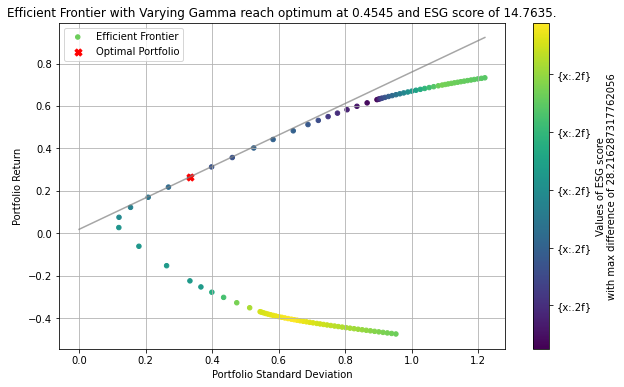

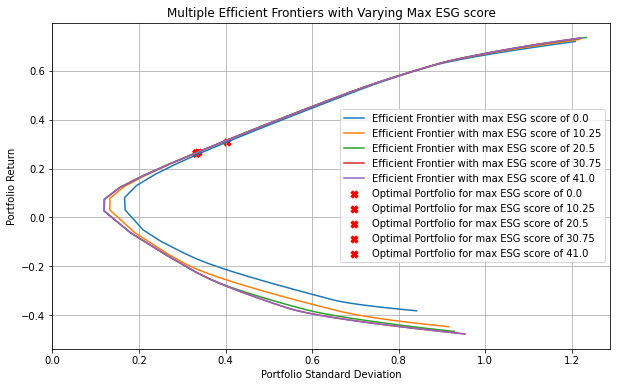

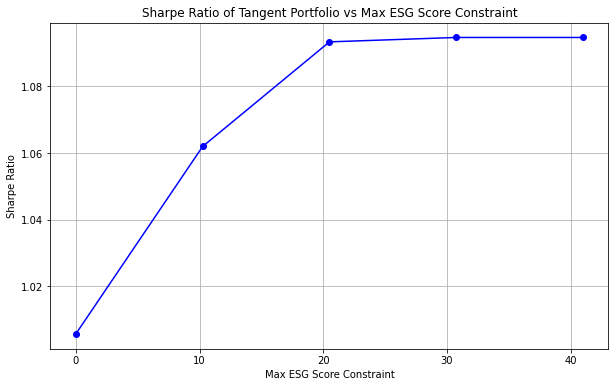

In [137]:
TICKERS = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
START_DATE = '2019-01-01'
END_DATE = '2023-12-01'
INTERVAL = '1mo' # '1d', '1y'
# Sustainalytics scores of the stocks (the smaller the better)
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3, 24, 15, 29, 17, 13, 41, 25]


Y_PORTFOLIO_best_in_class=Portfolio(TICKERS,
                      START_DATE,
                      END_DATE,
                      INTERVAL,
                      SUSTAINALYTICS_SCORES,'Y')

                      
Y_PORTFOLIO_best_in_class.download_data()

MAX_ESG_SCORE = 40
# propostion of risk-free asset in the portfolio
ALPHA = 0.9
# risk-free rate treasury bill 3 months
RISK_FREE_RATE = 0.018
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100) 

MAX_ESG_SCORES = list(np.linspace(0, np.max(SUSTAINALYTICS_SCORES), 5))

Y_PORTFOLIO_best_in_class.plot_efficient_frontier(GAMMA_VALUES, 
                                  ALPHA,
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=False,best_in_class_method=True)

Y_PORTFOLIO_best_in_class.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES,
                                                            ALPHA,
                                                            risk_free_rate=RISK_FREE_RATE,
                                                            max_esg_scores=MAX_ESG_SCORES,
                                                            fully_invested=True,
                                                            long_only=False,best_in_class_method=True,
                                                            with_optimal_portfolio=True,
                                                            with_linear_tangent=False)
Y_PORTFOLIO_best_in_class.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        ALPHA,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=False,best_in_class_method=True)    

Indice de controverse : le score devient une loi normale $\mathcal{N}(Score,Score_{controverse})$

Voir Roncalli sur la partie incertitude 

Re-rédiger proprement un notebook qui retrace l'histo de nos travaux